In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [51]:
# Load data
train_data = pd.read_csv("../../data/raw/train.csv")
test_data = pd.read_csv("../../data/raw/test.csv")

In [52]:
train_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [53]:
# Function to convert datetime column
def convert_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Extract date and time components
    df['year'] = df['datetime'].dt.year
    df['year'] = df['year'] - np.min(df['year'] - 1)
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour

    return df

# Apply datetime conversion to both train and test datasets
train_data = convert_datetime(train_data)
test_data = convert_datetime(test_data)

In [54]:
# Save original columns for both train and test data
train_columns = train_data.columns
test_columns = test_data.columns

# Add dummy variables for train and test data
train_data['is_train'], train_data['is_test'] = True, False
test_data['is_train'], test_data['is_test'] = False, True

In [55]:
# Combine train and test datasets based on datetime order
combined_data = pd.concat([train_data, test_data], axis=0).sort_values('datetime').reset_index(drop=True)

# Save length of train dataset
n_train = len(train_data)

# Reset index
combined_data = combined_data.reset_index(drop=True)

In [56]:
combined_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,is_train,is_test
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,1,1,1,0,True,False
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,1,1,1,1,True,False
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,1,1,1,2,True,False
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,1,1,1,3,True,False
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,1,1,1,4,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2,12,31,19,False,True
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2,12,31,20,False,True
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,2,12,31,21,False,True
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN,2,12,31,22,False,True


ADF Statistic: -16.988217
p-value: 0.000000
Distribution is stationary
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


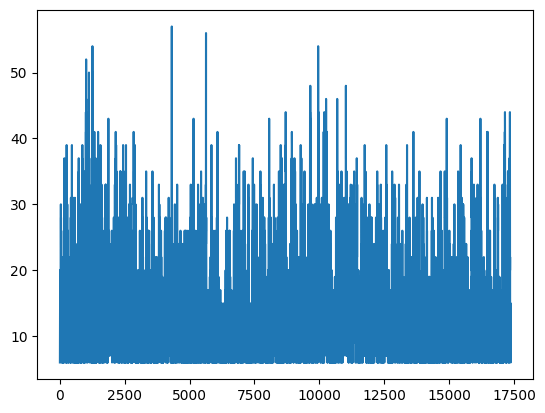

In [57]:
# Check for stationarity of wind speed
mask = combined_data['windspeed'] != 0
combined_data[mask]['windspeed'].plot()

# Check for stationarity of wind speed with hypothesis test
from statsmodels.tsa.stattools import adfuller

result = adfuller(combined_data[mask]['windspeed'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Print if the distribution is stationary or not
if result[1] < 0.05:
    print('Distribution is stationary')
else:
    print('Distribution is non-stationary')

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


In [58]:
def remove_outliers(df, column):
    # Calculate z-score
    z = np.abs((df[column] - df[column].mean()) / df[column].std())
    
    # Set outliers to zero
    df.loc[z > 3, column] = 0
    
    return df

# Remove outliers from windspeed
processed_data = remove_outliers(combined_data, 'windspeed')

In [59]:
def interpolate_wind_gaps(data):
    """
    Handles missing values in windspeed using interpolation.

    Parameters:
    data (DataFrame): The combined dataset containing the windspeed column.

    Returns:
    DataFrame: The combined dataset with the interpolated windspeed values.
    """

    # Convert windspeed column to numeric, replacing non-numeric values with NaN
    data['windspeed'] = pd.to_numeric(data['windspeed'], errors='coerce')

    # Set to zero negative values in windspeed
    data['windspeed'] = data['windspeed'].apply(lambda x: 0 if x < 0 else x)

    # Replace 0 values in windspeed with NaN
    data['windspeed_interp'] = data['windspeed'].replace(0, np.nan)

    # Count number of missing values in windspeed_interp
    n_missing = data['windspeed_interp'].isnull().sum()
    print(f"Number of missing values in windspeed_interp: {n_missing}")

    # Interpolate missing values in windspeed column
    data['windspeed_interp'] = data['windspeed_interp'].interpolate(method='spline', order=3)

    # Count number of missing values in windspeed_interp
    n_missing = data['windspeed_interp'].isnull().sum()
    print(f"Number of missing values in windspeed_interp after interpolation: {n_missing}")

    return data

# Apply fill_wind_gaps function to the combined dataset
processed_data = interpolate_wind_gaps(processed_data)

# Use bfill and ffill to fill remaining missing values
processed_data = processed_data.bfill()
processed_data = processed_data.ffill()
print(f'Number of missing values in windspeed_interp after everything: {processed_data.isnull().sum().sum()}')

Number of missing values in windspeed_interp: 2287
Number of missing values in windspeed_interp after interpolation: 5
Number of missing values in windspeed_interp after everything: 0


In [60]:
def smooth_features(processed_data, features_to_smooth):
    """
    Smooths features using a rolling average.

    Parameters:
    processed_data (DataFrame): The combined dataset containing the features to smooth.
    features_to_smooth (list): A list of features to smooth.

    Returns:
    DataFrame: The combined dataset with the smoothed features.
    """

    # Smooth features using a rolling average
    for feature in features_to_smooth:
        # Create a new feature with the smoothed values
        processed_data[feature] = processed_data[feature].rolling(window=3, min_periods = 1, center = True).mean()

    return processed_data

# Apply smooth_features function to the combined dataset
features_to_smooth = ['temp', 'atemp', 'windspeed_interp', 'humidity']
processed_data = smooth_features(processed_data, features_to_smooth)

In [61]:
processed_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,is_train,is_test,windspeed_interp
0,2011-01-01 00:00:00,1,0,0,1,9.430000,14.015000,80.500000,0.0000,3.0,13.0,16.0,1,1,1,0,True,False,6.003200
1,2011-01-01 01:00:00,1,0,0,1,9.293333,13.888333,80.333333,0.0000,8.0,32.0,40.0,1,1,1,1,True,False,6.003200
2,2011-01-01 02:00:00,1,0,0,1,9.293333,13.888333,78.333333,0.0000,5.0,27.0,32.0,1,1,1,2,True,False,6.003200
3,2011-01-01 03:00:00,1,0,0,1,9.566667,14.141667,76.666667,0.0000,3.0,10.0,13.0,1,1,1,3,True,False,6.003200
4,2011-01-01 04:00:00,1,0,0,1,9.840000,13.890000,75.000000,0.0000,0.0,1.0,1.0,1,1,1,4,True,False,6.003200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.660000,13.131667,56.000000,11.0014,4.0,84.0,88.0,2,12,31,19,False,True,10.333633
17375,2012-12-31 20:00:00,1,0,1,2,10.660000,12.880000,60.000000,11.0014,4.0,84.0,88.0,2,12,31,20,False,True,11.001400
17376,2012-12-31 21:00:00,1,0,1,1,10.660000,13.131667,58.666667,11.0014,4.0,84.0,88.0,2,12,31,21,False,True,10.333633
17377,2012-12-31 22:00:00,1,0,1,1,10.660000,13.383333,60.333333,8.9981,4.0,84.0,88.0,2,12,31,22,False,True,9.665867


In [62]:
def create_lagged_features(processed_data):
    """
    Create lagged features for wind, humidity, and temperature.

    Args:
        processed_data (pd.DataFrame): Processed data containing the columns 'windspeed_interp', 'humidity', and 'temp'.

    Returns:
        tuple: A tuple containing two DataFrames - lagged_features_wind and lagged_features_not_wind.
            lagged_features_wind (pd.DataFrame): DataFrame containing lagged features for wind.
            lagged_features_not_wind (pd.DataFrame): DataFrame containing lagged features for humidity and temperature.
    """

    lagged_features_wind = pd.DataFrame()
    lagged_features_not_wind = pd.DataFrame()
    wind_lags = [8, 7, 6, 5, 4, 3, 2, 1, 24, 48, 72]
    humidity_lags = [3, 2, 1]
    temp_lags = [3, 2, 1]

    for lag in wind_lags:
        current = processed_data['windspeed_interp']
        lag_1 = current.shift(lag)
        lag_2 = current.shift(-lag)
        
        lagged_features_wind[f'wind, t-{lag}'] = lag_1
        lagged_features_wind[f'wind, t+{lag}'] = lag_2

        # If the first one is missing, replace with current value + difference between current and second value
        lagged_features_wind[f'wind, t-{lag}'] = lagged_features_wind[f'wind, t-{lag}'].combine_first(current + (current - lag_2))

        # If the second one is missing, replace with current value + difference between current and first value
        lagged_features_wind[f'wind, t+{lag}'] = lagged_features_wind[f'wind, t+{lag}'].combine_first(current + (current - lag_1))

        
    for lag in humidity_lags:
        current = processed_data['humidity']
        lag_1 = current.shift(lag)
        lag_2 = current.shift(-lag)

        lagged_features_not_wind[f'hum, t-{lag}'] = lag_1
        lagged_features_not_wind[f'hum, t+{lag}'] = lag_2

        # If the first one is missing, replace with current value + difference between current and second value
        lagged_features_not_wind[f'hum, t-{lag}'] = lagged_features_not_wind[f'hum, t-{lag}'].combine_first(current + (current - lag_2))

        # If the second one is missing, replace with current value + difference between current and first value
        lagged_features_not_wind[f'hum, t+{lag}'] = lagged_features_not_wind[f'hum, t+{lag}'].combine_first(current + (current - lag_1))

    for lag in temp_lags:
        current = processed_data['temp']
        lag_1 = current.shift(lag)
        lag_2 = current.shift(-lag)

        lagged_features_not_wind[f'temp, t-{lag}'] = lag_1
        lagged_features_not_wind[f'temp, t+{lag}'] = lag_2

        # If the first one is missing, replace with current value + difference between current and second value
        lagged_features_not_wind[f'temp, t-{lag}'] = lagged_features_not_wind[f'temp, t-{lag}'].combine_first(current + (current - lag_2))

        # If the second one is missing, replace with current value + difference between current and first value
        lagged_features_not_wind[f'temp, t+{lag}'] = lagged_features_not_wind[f'temp, t+{lag}'].combine_first(current + (current - lag_1))

    return lagged_features_wind, lagged_features_not_wind

# Apply create_lagged_features function to the combined dataset
lagged_features_wind, lagged_features_not_wind = create_lagged_features(processed_data)


In [63]:
def combine_features(processed_data, lagged_features_wind, lagged_features_not_wind, use_wind=True):
    """
    Combines the original features with the lagged features.

    Parameters:
    processed_data (DataFrame): The combined dataset containing the original features.
    lagged_features_wind (DataFrame): The lagged wind features.
    lagged_features_not_wind (DataFrame): The lagged features that are not wind.
    use_wind (bool): Whether to include the wind lagged features.

    Returns:
    DataFrame: The combined dataset with the lagged features.
    """

    # Combine original features with lagged features
    if use_wind:
        processed_data = pd.concat([processed_data, lagged_features_wind], axis=1)
    
    processed_data = pd.concat([processed_data, lagged_features_not_wind], axis=1)

    return processed_data

# Apply combine_features function to the combined dataset
final_data = combine_features(processed_data, lagged_features_wind, lagged_features_not_wind, use_wind=True)
print(len(final_data))

17379


In [64]:
final_data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'is_train', 'is_test',
       'windspeed_interp', 'wind, t-8', 'wind, t+8', 'wind, t-7', 'wind, t+7',
       'wind, t-6', 'wind, t+6', 'wind, t-5', 'wind, t+5', 'wind, t-4',
       'wind, t+4', 'wind, t-3', 'wind, t+3', 'wind, t-2', 'wind, t+2',
       'wind, t-1', 'wind, t+1', 'wind, t-24', 'wind, t+24', 'wind, t-48',
       'wind, t+48', 'wind, t-72', 'wind, t+72', 'hum, t-3', 'hum, t+3',
       'hum, t-2', 'hum, t+2', 'hum, t-1', 'hum, t+1', 'temp, t-3',
       'temp, t+3', 'temp, t-2', 'temp, t+2', 'temp, t-1', 'temp, t+1'],
      dtype='object')

In [65]:
# Separate data with missing windspeed values and with valid windspeed values
missing_wind_mask = final_data['windspeed'] == 0
data_with_missing_wind = final_data[missing_wind_mask]
data_without_missing_wind = final_data[~missing_wind_mask]
print(len(data_with_missing_wind), len(data_without_missing_wind))

# Define features not to use in traning and target variable
features_to_drop = ['windspeed', 'holiday', 'workingday', 
                    'casual', 'registered', 'count', 
                    'windspeed_interp', 'year', 'day',
                    'season', 'datetime', 'month',
                    'is_train', 'is_test', 'weather']

target_variable = 'windspeed'

2287 15092


In [66]:
# Split data into train and test sets
wind_train, wind_test = train_test_split(data_without_missing_wind, test_size=0.2, random_state=10)

# Define features to use in training
wind_features = [col for col in wind_train.columns if col not in features_to_drop]

X_train, y_train = wind_train[wind_features], wind_train[target_variable]
X_test, y_test = wind_test[wind_features], wind_test[target_variable]

In [67]:
# Pipeline for neural network model
neural_net_pipe = make_pipeline(StandardScaler(), MLPRegressor(verbose=True, max_iter=500))
neural_net_pipe.fit(X_train, y_train)

# Pipeline for random forest model
random_forest_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(verbose=True, ))
random_forest_pipe.fit(X_train, y_train)

Iteration 1, loss = 88.06054115
Iteration 2, loss = 31.14634364
Iteration 3, loss = 15.33192767
Iteration 4, loss = 12.29135107
Iteration 5, loss = 10.55385955
Iteration 6, loss = 9.27532609
Iteration 7, loss = 8.22393512
Iteration 8, loss = 7.29786656
Iteration 9, loss = 6.47694837
Iteration 10, loss = 5.74550113
Iteration 11, loss = 5.09427590
Iteration 12, loss = 4.51997261
Iteration 13, loss = 3.99665866
Iteration 14, loss = 3.54316094
Iteration 15, loss = 3.14189965
Iteration 16, loss = 2.79099576
Iteration 17, loss = 2.49304159
Iteration 18, loss = 2.22353537
Iteration 19, loss = 2.00056205
Iteration 20, loss = 1.81184101
Iteration 21, loss = 1.65089401
Iteration 22, loss = 1.50355202
Iteration 23, loss = 1.37908637
Iteration 24, loss = 1.27133012
Iteration 25, loss = 1.17530318
Iteration 26, loss = 1.09186755
Iteration 27, loss = 1.01627543
Iteration 28, loss = 0.95074935
Iteration 29, loss = 0.89243486
Iteration 30, loss = 0.84175581
Iteration 31, loss = 0.79752117
Iteration 32

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    9.1s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor(verbose=True))])

In [68]:
# Compare predictions from both models
neural_net_pred = neural_net_pipe.predict(X_test)
random_forest_pred = random_forest_pipe.predict(X_test)

# Calculate mean squared error for both models
neural_net_mse = np.mean((neural_net_pred - y_test) ** 2)
random_forest_mse = np.mean((random_forest_pred - y_test) ** 2)

# Print the mean squared error for both models
print(f"Neural Network MSE: {neural_net_mse}")
print(f"Random Forest MSE: {random_forest_mse}")
print('')
print(f"Neural Network R2: {neural_net_pipe.score(X_test, y_test)}")
print(f"Random Forest R2: {random_forest_pipe.score(X_test, y_test)}")

print('')

# Create and print most important variables dataframe from random forest model
importances = random_forest_pipe.named_steps['randomforestregressor'].feature_importances_
importances_df = pd.DataFrame(importances, index=wind_features, columns=['importance'])
importances_df = importances_df.sort_values(by='importance', ascending=False)

#print dataframe with rounded importance values
print(importances_df.round(5))

Neural Network MSE: 1.0526098941945468
Random Forest MSE: 2.819279320969503

Neural Network R2: 0.9766266487723232
Random Forest R2: 0.9373975048672996

            importance
wind, t-1      0.57447
wind, t+1      0.31730
wind, t-2      0.02736
wind, t+2      0.02690
wind, t-4      0.00344
wind, t+4      0.00329
wind, t-3      0.00300
wind, t+3      0.00298
wind, t+24     0.00239
wind, t+48     0.00237
wind, t-48     0.00231
wind, t-24     0.00229
wind, t-72     0.00227
wind, t+72     0.00223
wind, t+8      0.00179
hour           0.00172
wind, t-8      0.00168
wind, t+5      0.00157
wind, t-5      0.00153
wind, t+6      0.00150
wind, t-7      0.00150
wind, t-6      0.00150
hum, t+3       0.00141
wind, t+7      0.00141
hum, t-3       0.00136
hum, t+2       0.00111
hum, t+1       0.00101
hum, t-2       0.00100
humidity       0.00096
hum, t-1       0.00091
temp, t-3      0.00090
temp, t+3      0.00088
temp, t-2      0.00067
atemp          0.00067
temp, t+2      0.00063
temp, t-1      0.00

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [69]:
# Combine predictions from both models using a weighted average
neural_net_weight = 0.5
random_forest_weight = 1 - neural_net_weight

def calculate_mse(weight):

    # Calculate the combined prediction using the given weights
    combined_pred = (weight * neural_net_pred) + ((1-weight) * random_forest_pred)

    # Calculate the mean squared error of the combined model
    mse = np.mean((combined_pred - y_test) ** 2)

    return mse

# Run an optimiser on the weights to find the best combination using scipy.minimise
from scipy.optimize import minimize

# Define the initial weights
initial_weight = neural_net_weight

# Run the optimiser
result = minimize(calculate_mse, initial_weight)

# Print the optimised weights and mean squared error
print("Minimised MSE: ",result.fun)
print("Minimised MAE: ", np.mean(np.abs(result.x * neural_net_pred + (1-result.x) * random_forest_pred - y_test)))
print("Optimised weights: ", result.x[0], 1-result.x[0])


Minimised MSE:  1.0367347461777598
Minimised MAE:  0.7828161510572886
Optimised weights:  0.9137668799680299 0.08623312003197015


In [70]:
# Predict windspeed for data with missing values
missing_wind_features = [col for col in data_with_missing_wind.columns if col not in features_to_drop]
missing_wind_pred = (result.x * neural_net_pipe.predict(data_with_missing_wind[missing_wind_features])) + ((1-result.x) * random_forest_pipe.predict(data_with_missing_wind[missing_wind_features]))

# Replace missing windspeed values with predictions
combined_data.loc[missing_wind_mask, 'windspeed'] = missing_wind_pred

# Divide back into train and test datasets using the 'is_train' and 'is_test' columns
train_data = combined_data[combined_data['is_train']]
test_data = combined_data[combined_data['is_test']]

# Keep only the original columns
train_data = train_data[train_columns]
test_data = test_data[test_columns]

# reset index
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [71]:
train_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,6.479491,3.0,13.0,16.0,1,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,6.512716,8.0,32.0,40.0,1,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,6.485972,5.0,27.0,32.0,1,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,5.462380,3.0,10.0,13.0,1,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,10.252328,0.0,1.0,1.0,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.002700,7.0,329.0,336.0,2,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.001300,10.0,231.0,241.0,2,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.001300,4.0,164.0,168.0,2,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.003200,12.0,117.0,129.0,2,12,19,22


In [72]:
# Save the processed data
train_data.to_csv("../../data/processed/train_with_wind.csv", index=False)
test_data.to_csv("../../data/processed/test_with_wind.csv", index=False)